In [1]:
import pandas as pd
import os
from Bio import SeqIO
#http://mendel.imp.ac.at/sat/gpi/gpi_server.html
#http://gpcr2.biocomp.unibo.it/predgpi/
#https://services.healthtech.dtu.dk/software.php signalP Version 5.0b

In [63]:
#stats on two set python objects
def compare_sets(s1=set(),s2=set(),name1='s1',name2='s2'):
    common = len(set(s1) & set(s2))
    uS1 = len(set(s1) - set(s2))
    uS2 = len(set(s2) - set(s1))
    res = pd.DataFrame(columns=[name1,name2])
    res.loc['size',:]=[len(s1),len(s2)]
    res.loc['common',:]=[common,common]
    res.loc['unique',:]=[uS1,uS2]
    str_report="""
    {lenS1} in {s1}
    {lenS2} in {s2} 
    {common} in common
    {uS1} unique {s1}
    {uS2} unique in {s2}
    """.format(
        s1 = res.columns[0],
        s2 = res.columns[1],
        lenS1 = res.loc['size',res.columns[0]],
        lenS2 = res.loc['size',res.columns[1]],
        common=res.loc['common',res.columns[0]],
        uS1 = res.loc['unique',res.columns[0]],
        uS2 = res.loc['unique',res.columns[1]],
              )
    return str_report,res


#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(';')[0].split('-')[0]
    return temp_id

#lets see if the proteins are identified in Rupa mass spec data
#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')


        
#remove rubbish entires from a
#maxquant output
def clean_df(df, id_by_site=True, rev_database=True, 
             contaminant=True, score=False, unique_pep_threshold=2):  
    before,start = df.shape,df.shape
    print('starting from:', before)
    if id_by_site:
        #remove Only identified by site
        before,start = df.shape,df.shape
        col = 'Only identified by site'
        df = df[df[col] != '+'] 
        print_result(start, before, df, col)
    
    if rev_database:
        #remove hits from reverse database
        before = df.shape
        col = 'Reverse'
        df = df[df[col] != '+']
        print_result(start, before, df, col)
     

    if contaminant:
        #remove contaminants (mainly keratine and bsa)
        before = df.shape
        col = 'Potential contaminant'
        df = df[df[col] != '+']
        print_result(start, before, df, col)

    if score:
        before = df.shape
        col = 'Score'
        df = df[df[col] >= score]
        print_result(start, before, df, col)
        
        
    ##remove protein groups with less thatn 2 unique peptides
    before = df.shape
    col = 'Peptide counts (unique)'
    df['unique_int'] = [int(n.split(';')[0]) for n in df[col]]
    df = df[df['unique_int'] >= unique_pep_threshold]
    print_result(start, before, df, col)
    return df

#extract the description from the fasta headers
#of the proten group
def make_desc(n, lookfor='gene_product'):
    temp_dict = {}
    n=str(n)
    if 'sp|' in n:
        item_list = n.split(';')
        desc = []
        for n in item_list[0].split(' '):
            if '=' not in n and 'sp|' not in n:
                desc.append(n)
            if '=' in n:
                break
        desc = ' '.join(desc)
        return desc
           
    item_list = n.split(' | ')
    for n in item_list:
        if '=' in n:
            key = n.split('=')[0].strip()
            value= n.split('=')[1].strip()
            temp_dict[key]=value

                  
    return temp_dict.get(lookfor,'none')


#rename some of maxquant output 
#columns
def mod_df(df, desc_from_id=False, desc_value='gene_product' ):
    df['Gene_id'] = [clean_id(n.split(':')[0].split(';')[0])
                     for n in df['Protein IDs']]
    df['desc'] = df['Fasta headers'].apply(make_desc, lookfor=desc_value)
    return df


In [64]:
def make_table(genes):
    glist = open(genes).read().split(', ')
    glist = [n.strip() for n in glist]
    glist = [n for n in glist if  len(n) > 2]
    return glist
fnames = ['OG0000004','OG0000013','OG0000031','OG0000108']
for fname in fnames:
    glist = make_table('in_data_theileri/{}.txt'.format(fname))
    open('{}_in.txt'.format(fname),'w').write('\n'.join(glist))


In [65]:
def assemble():
    df_list = []
    temp = pd.read_csv('in_data_theileri/TryTripDB/GP63/GenesByTextSearch_Summary.txt',sep='\t')
    temp=temp.iloc[:,0:-1]
    temp['class']='MSP'
    
    df_list.append(temp)
    fnames = ['TTPSP1','TTPSP2','TTPSP3','TTPSP4']
    for fname in fnames:
        temp = pd.read_csv('in_data_theileri/TryTripDB/{}/GeneByLocusTag_Summary.txt'.format(fname),
                          sep='\t')
        temp=temp.iloc[:,0:-1]
        temp['class']=fname
        df_list.append(temp)
    df_list = pd.concat(df_list)
    return df_list
df_list = assemble()
print(df_list.groupby('class')['Gene ID'].size())
df_list.head()

class
MSP       200
TTPSP1    556
TTPSP2    304
TTPSP3    145
TTPSP4     61
Name: Gene ID, dtype: int64


,Gene ID,source_id,Organism,Genomic Location (Gene),Product Description,Found in,Score,class,Gene Type,Input ID
0,TM35_000016340,TM35_000016340-t36_1,T. theileri isolate Edinburgh,"NBCO01000001:1,362,860..1,364,512(+)",surface protease GP63,Product,1.0,MSP,NaN,NaN
1,TM35_000016360,TM35_000016360-t36_1,T. theileri isolate Edinburgh,"NBCO01000001:1,366,015..1,367,550(+)",putative surface protease GP63,Product,1.0,MSP,NaN,NaN
2,TM35_000021490,TM35_000021490-t36_1,T. theileri isolate Edinburgh,"NBCO01000002:129,917..130,852(-)",surface protease GP63,Product,1.0,MSP,NaN,NaN
3,TM35_000021510,TM35_000021510-t36_1,T. theileri isolate Edinburgh,"NBCO01000002:133,107..135,770(-)",surface protease GP63,Product,1.0,MSP,NaN,NaN
4,TM35_000022110,TM35_000022110-t36_1,T. theileri isolate Edinburgh,"NBCO01000002:330,899..332,599(-)",putative surface protease GP63,Product,1.0,MSP,NaN,NaN


In [66]:
df_list=df_list[['Gene ID','Product Description','class']]
#df_list.set_index('Gene ID',inplace=True)
df_list.head()

,Gene ID,Product Description,class
0,TM35_000016340,surface protease GP63,MSP
1,TM35_000016360,putative surface protease GP63,MSP
2,TM35_000021490,surface protease GP63,MSP
3,TM35_000021510,surface protease GP63,MSP
4,TM35_000022110,putative surface protease GP63,MSP


In [67]:
df_list['is_mucin']=[1 if n.startswith('TTPSP') else 0 for n in df_list['class']]
df_list['is_mucin'].value_counts()

1    1066
0     200
Name: is_mucin, dtype: int64

In [68]:
path = os.path.join('in_data_theileri','combined_Trypanosoma_theileri_prot',
                   'txt','proteinGroups.txt')
df = pd.read_csv(path,sep='\t')
df = clean_df(df)
df = mod_df(df)
#df['[Gene ID]']=[clean_id(n) for n in df['Protein IDs']]
#df['Gene ID']=[n.split(';')[0] for n in df['Protein IDs']]
#df['unique_pepties']=[int(n.split(';')[0]) for n in df['Peptide counts (unique)']]
#df=df.drop_duplicates('[Gene ID]')
#df=df[df['unique_pepties']>=2]
#df=df[df['Score']>=5]
print(df.shape)
df.head()

starting from: (1346, 32)
removed  16 Only identified by site
tot  16  entries removed
---------------
removed  13 Reverse
tot  29  entries removed
---------------
removed  26 Potential contaminant
tot  55  entries removed
---------------
removed  420 Peptide counts (unique)
tot  475  entries removed
---------------
(871, 35)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int,Gene_id,desc
41,TM35_000011040-t36_1-p1,TM35_000011040-t36_1-p1,2,2,2,TM35_000011040-t36_1-p1 | transcript=TM35_0000...,1,2,2,2,...,True;True,2420;2915,2955;3575,5640;6748,5640;6748,NaN,NaN,2,TM35_000011040,hypothetical protein
42,TM35_000011140-t36_1-p1,TM35_000011140-t36_1-p1,2,2,2,TM35_000011140-t36_1-p1 | transcript=TM35_0000...,1,2,2,2,...,True;True,1702;3929,2093;4841,4026;9241;9242,4026;9241,NaN,NaN,2,TM35_000011140,adenylate kinase
43,TM35_000011170-t36_1-p1,TM35_000011170-t36_1-p1,6,6,6,TM35_000011170-t36_1-p1 | transcript=TM35_0000...,1,6,6,6,...,True;True;True;True;True;True,234;254;520;606;2642;4035,284;310;619;740;3235;4961,529;566;1129;1353;1354;6147;6148;9448,529;566;1129;1354;6147;9448,NaN,NaN,6,TM35_000011170,putative malate dehydrogenase
44,TM35_000011230-t36_1-p1,TM35_000011230-t36_1-p1,6,6,6,TM35_000011230-t36_1-p1 | transcript=TM35_0000...,1,6,6,6,...,True;True;True;True;True;True,666;1076;1723;1939;2528;4163,813;814;1328;1329;1330;1331;2116;2383;3099;310...,1491;1492;1493;1494;1495;2567;2568;2569;2570;2...,1491;2568;4075;4600;5901;9742,NaN,NaN,6,TM35_000011230,hypothetical protein
45,TM35_000011270-t36_1-p1,TM35_000011270-t36_1-p1,5,5,5,TM35_000011270-t36_1-p1 | transcript=TM35_0000...,1,5,5,5,...,True;True;True;True;True,2247;2511;3760;3991;4187,2751;3081;4639;4909;5155,5275;5872;8875;9366;9821,5275;5872;8875;9366;9821,NaN,NaN,5,TM35_000011270,hypothetical protein


In [69]:
print(df.shape)
df=df.merge(df_list,left_on='Gene_id',right_on='Gene ID',how='left')
print(df.shape)
df.head()

(871, 35)
(871, 39)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int,Gene_id,desc,Gene ID,Product Description,class,is_mucin
0,TM35_000011040-t36_1-p1,TM35_000011040-t36_1-p1,2,2,2,TM35_000011040-t36_1-p1 | transcript=TM35_0000...,1,2,2,2,...,5640;6748,NaN,NaN,2,TM35_000011040,hypothetical protein,NaN,NaN,NaN,NaN
1,TM35_000011140-t36_1-p1,TM35_000011140-t36_1-p1,2,2,2,TM35_000011140-t36_1-p1 | transcript=TM35_0000...,1,2,2,2,...,4026;9241,NaN,NaN,2,TM35_000011140,adenylate kinase,NaN,NaN,NaN,NaN
2,TM35_000011170-t36_1-p1,TM35_000011170-t36_1-p1,6,6,6,TM35_000011170-t36_1-p1 | transcript=TM35_0000...,1,6,6,6,...,529;566;1129;1354;6147;9448,NaN,NaN,6,TM35_000011170,putative malate dehydrogenase,NaN,NaN,NaN,NaN
3,TM35_000011230-t36_1-p1,TM35_000011230-t36_1-p1,6,6,6,TM35_000011230-t36_1-p1 | transcript=TM35_0000...,1,6,6,6,...,1491;2568;4075;4600;5901;9742,NaN,NaN,6,TM35_000011230,hypothetical protein,NaN,NaN,NaN,NaN
4,TM35_000011270-t36_1-p1,TM35_000011270-t36_1-p1,5,5,5,TM35_000011270-t36_1-p1 | transcript=TM35_0000...,1,5,5,5,...,5275;5872;8875;9366;9821,NaN,NaN,5,TM35_000011270,hypothetical protein,NaN,NaN,NaN,NaN


In [70]:
df['TTPSP']=[1 if str(n).startswith('TTPSP') else 0 for n in df['class']]

In [71]:
df.groupby('class').size()

class
MSP         4
TTPSP1    272
TTPSP2    120
TTPSP3     43
TTPSP4     33
dtype: int64

In [72]:
df.groupby('TTPSP').size()

TTPSP
0    403
1    468
dtype: int64

In [73]:
#s1=set(df['[Gene ID]'])
#s2=set(predicted_mucin['[Gene ID]'])

#res= compare_sets(s1,s2,name1='proteomics',name2='predicted mucin')
#print(res[0])

## Retrive GPI
### big-PI Predictor

In [74]:
def parse_fasta():
    from Bio import SeqIO
    for infile in os.listdir('fasta_prot'):
        if infile.endswith('.fasta'):
            with open('fasta_prot/'+infile, "rU") as handle, open('fasta_prot/'+infile.split('.')[0]+'_parsed.fa', "w") as out:
                for record in SeqIO.parse(handle, "fasta"):
                    #if record.id == 'TCSYLVIO_006765-t26_1-p1':
                    #    print(len(str(record.seq)))
                    #    print(record.id)
                    seq = str(record.seq)
                    seq = seq.replace('X','A').replace('*','A')
                    if len(seq)<30:
                        fold = int(30/len(seq))
                        seq = seq+(seq*(fold+1))
                    #print(str(record))
                    out.write('>'+record.id+'\n'+str(seq)+'\n')           

In [75]:
def get_pred(infile,out,model='protozoa'): #metazoa):
    #infile = 'fasta_prot/TriTrypDB-39_TcruziSylvioX10-1-2012_AnnotatedProteins_parsed.fa'
    #out = 'bigPI/tcruzi.txt'
    #infile = 'fasta_prot/TriTrypDB-46_TbruceiTREU927_AnnotatedProteins_parsed.fa'
    #out = 'bigPI/tbrucei.txt'
    #infile = 'fasta_prot/TriTrypDB-39_TtheileriEdinburgh_AnnotatedProteins_parsed.fa'
    #out = 'bigPI/tthel.txt'

    from urllib.parse import urlencode
    from urllib.request import Request, urlopen
    infile = open(infile).read()
    url = 'http://mendel.imp.ac.at/gpi/cgi-bin/gpi_pred.cgi' # Set destination URL here
    post_fields = {'LSet': model, 'Sequence': infile}
    request = Request(url, urlencode(post_fields).encode())
    json = urlopen(request).read().decode()
    open(out,'w').write(json)

In [76]:
def run():
    infile = 'fasta_prot/TriTrypDB-46_TbruceiTREU927_AnnotatedProteins_parsed.fa'
    out = 'bigPI/tbrucei_metazoa.txt'
    get_pred(infile,out,model='metazoa')

In [77]:
def run():
    infile = 'fasta_prot/TriTrypDB-46_TbruceiTREU927_AnnotatedProteins_parsed.fa'
    out = 'bigPI/tbrucei_protozoa.txt'
    get_pred(infile,out,model='protozoa')

In [78]:
def parse_predGPI(infile):
    res = {}
    for l in open(infile):
        if l.startswith('> '):
            gene_id = l.replace('> ','').strip()
        if l.startswith('Extimated False'):
            score = float(l.split(' = ')[1].strip())
        if l.startswith('GPI-Anchor '):  
            site = int(l.split('= ')[1].strip())
            res[gene_id]=(site, score)
    return res

def parse_bigPI(infile):
    read_file = open(infile).readlines()
    res = {}
    for index,l in enumerate(read_file):
        if l.startswith('Query sequence '):
            gene_id = l.split(' ')[2].strip()
        if l.startswith('Potential GPI'):
            site = read_file[index+2].split()[-1]
            site = site.split('<')[0]
            int(site)
            score = read_file[index+3].split()[-1].replace(')','')
            float(score)
            res[gene_id]=(site, score)
    return res


In [79]:
df['protein_ids']=[n.split(';')[0] for n in df['Protein IDs']]
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Oxidation (M) site positions,unique_int,Gene_id,desc,Gene ID,Product Description,class,is_mucin,TTPSP,protein_ids
0,TM35_000011040-t36_1-p1,TM35_000011040-t36_1-p1,2,2,2,TM35_000011040-t36_1-p1 | transcript=TM35_0000...,1,2,2,2,...,NaN,2,TM35_000011040,hypothetical protein,NaN,NaN,NaN,NaN,0,TM35_000011040-t36_1-p1
1,TM35_000011140-t36_1-p1,TM35_000011140-t36_1-p1,2,2,2,TM35_000011140-t36_1-p1 | transcript=TM35_0000...,1,2,2,2,...,NaN,2,TM35_000011140,adenylate kinase,NaN,NaN,NaN,NaN,0,TM35_000011140-t36_1-p1
2,TM35_000011170-t36_1-p1,TM35_000011170-t36_1-p1,6,6,6,TM35_000011170-t36_1-p1 | transcript=TM35_0000...,1,6,6,6,...,NaN,6,TM35_000011170,putative malate dehydrogenase,NaN,NaN,NaN,NaN,0,TM35_000011170-t36_1-p1
3,TM35_000011230-t36_1-p1,TM35_000011230-t36_1-p1,6,6,6,TM35_000011230-t36_1-p1 | transcript=TM35_0000...,1,6,6,6,...,NaN,6,TM35_000011230,hypothetical protein,NaN,NaN,NaN,NaN,0,TM35_000011230-t36_1-p1
4,TM35_000011270-t36_1-p1,TM35_000011270-t36_1-p1,5,5,5,TM35_000011270-t36_1-p1 | transcript=TM35_0000...,1,5,5,5,...,NaN,5,TM35_000011270,hypothetical protein,NaN,NaN,NaN,NaN,0,TM35_000011270-t36_1-p1


In [80]:
#predGPI

In [81]:
bigPI = parse_bigPI('bigPI/tthel.txt')
print(len(bigPI))
predGPI = parse_predGPI('predGPI/tthei.txt')
print(len(predGPI))
def get_score(gene_id, dict_gpi):
    return dict_gpi.get(gene_id,('none','none'))

df["bigPI_site"], df["bigPI_score"] = zip(*df['protein_ids'].apply(get_score,args=(bigPI,)))
df["predGPI_site"], df["predGPI_score"] = zip(*df['protein_ids'].apply(get_score,args=(predGPI,)))

df["predGPI_pred"] = [1 if n < 0.01 else 0 for n in df["predGPI_score"]]
df["bigPI_pred"] = [1 if n != 'none' else 0 for n in df["bigPI_score"]]
df['tot_pred_GPI']=df["bigPI_pred"]+df["predGPI_pred"]
df['tot_pred_GPI'] = [1 if n > 0 else 0 for n in df['tot_pred_GPI']]
print(df['tot_pred_GPI'].value_counts())

787
11312
0    449
1    422
Name: tot_pred_GPI, dtype: int64


In [82]:
sigP = pd.read_csv('signalP5/tthe_summary.signalp5',comment='#',sep='\t',
                  names=['ID','Prediction_sigP','SP(Sec/SPI)','OTHER','CS Position'])
sigP[['ID','Prediction_sigP','CS Position']].head()

,ID,Prediction_sigP,CS Position
0,TM35_000011000-t36_1-p1,OTHER,NaN
1,TM35_000011010-t36_1-p1,OTHER,NaN
2,TM35_000011020-t36_1-p1,OTHER,NaN
3,TM35_000011030-t36_1-p1,OTHER,NaN
4,TM35_000011040-t36_1-p1,OTHER,NaN


In [83]:
df=df.merge(sigP[['ID','Prediction_sigP','CS Position']],how='left',left_on=['protein_ids'],right_on='ID')
df['tot_pred_sigP']=[1 if str(n) != 'OTHER' else 0 for  n in df['Prediction_sigP']]
df['sig_pep_start']=[int(n.split(' ')[2].split('-')[0].strip())
                     if str(n) != 'nan' else 0 for n in df['CS Position']]

In [84]:
df['sigP_gpi'] = df['tot_pred_GPI']+df['tot_pred_sigP']
df['sigP_gpi']=[1 if n > 1 else 0 for n in df['sigP_gpi']]
df['sigP_gpi'].value_counts()

0    517
1    354
Name: sigP_gpi, dtype: int64

In [85]:
from Bio import SeqIO
seq_dict = {}
with open('fasta_prot/TriTrypDB-39_TtheileriEdinburgh_AnnotatedProteins_parsed.fa') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq = str(record.seq)
        prot_id = record.id
        seq_dict[prot_id]=seq
df['seq'] = [seq_dict[n] for n in df['ID']]

In [86]:
df['seq'].head()

0    MHVEFRISRIDNMCSFDAESFIRMHQLRHRPLLEASLRKSFVKLPE...
1    MKIVLMGAPGCGKGTQSPFLTERYGVCHLSTGDMLREAVARKTEYG...
2    MHSCALRYSKVAVLGAAGGIGQPLSLLLKNSPLVSALSCYDVRGAP...
3    MSASGDEVFPPILWAQRPEYVLVSIPLPDATDVSVEIRDGRVLHFH...
4    MNEFKSNGDAGIKNDANVVYSDRLMHSECGITPAYGVEVRESRPHI...
Name: seq, dtype: object

In [87]:
df['class']=df['class'].fillna('OTHER')

In [88]:
table_0 = df.groupby('class').size().reset_index()
table_0.columns = ['class','identified']
del table_0['class']
table_0

,identified
0,4
1,399
2,272
3,120
4,43
5,33


In [89]:
table_1 = df.groupby('class')[['sigP_gpi','tot_pred_sigP','tot_pred_GPI']].sum().reset_index()
table_1.columns = ['class','both','sigP','GPI']
table_0 = table_0.join(table_1)
table_0 = table_0[['class','identified','sigP','GPI','both']]
table_0['both %'] = (table_0['both']/table_0['identified'])*100
table_0['both %'] = table_0['both %'].round(1)
table_0

,class,identified,sigP,GPI,both,both %
0,MSP,4,4,3,3,75.0
1,OTHER,399,48,12,4,1.0
2,TTPSP1,272,241,234,207,76.1
3,TTPSP2,120,88,110,81,67.5
4,TTPSP3,43,38,41,37,86.0
5,TTPSP4,33,32,22,22,66.7


In [90]:
temp = df[df['sigP_gpi']==1]
temp['lenght']=temp['Sequence length']-temp['predGPI_site']-df['sig_pep_start']
temp = temp.groupby('class')[['lenght']].median().astype(int).reset_index()
del temp['class']
table_0 = table_0.join(temp)
table_0

<ipython-input-90-6159d886b574>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['lenght']=temp['Sequence length']-temp['predGPI_site']-df['sig_pep_start']


,class,identified,sigP,GPI,both,both %,lenght
0,MSP,4,4,3,3,75.0,606
1,OTHER,399,48,12,4,1.0,194
2,TTPSP1,272,241,234,207,76.1,269
3,TTPSP2,120,88,110,81,67.5,261
4,TTPSP3,43,38,41,37,86.0,348
5,TTPSP4,33,32,22,22,66.7,224


In [91]:
#temp.to_csv('temp.csv')

In [92]:
temp = df[df['sigP_gpi']==1]

In [93]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [94]:
def process_sequence(X):
    sequence = X['seq']
    gpi = X['predGPI_site']
    sigP = X['sig_pep_start']
    seq = sequence[sigP:-gpi]
    return seq
temp['processed_sequence'] = temp.apply(process_sequence,axis=1)    

<ipython-input-94-6300cdb265a0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['processed_sequence'] = temp.apply(process_sequence,axis=1)


In [95]:
temp['MW'] = [round(ProteinAnalysis(n).molecular_weight()/1000,2) for
                        n in temp['processed_sequence']]

<ipython-input-95-ce0be64265e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MW'] = [round(ProteinAnalysis(n).molecular_weight()/1000,2) for


In [96]:
temp = temp.groupby('class')[['MW']].median().reset_index()
del temp['class']
table_0 = table_0.join(temp)

In [97]:
table_0.to_csv('table_0.csv')

In [98]:
table_0

,class,identified,sigP,GPI,both,both %,lenght,MW
0,MSP,4,4,3,3,75.0,606,67.98
1,OTHER,399,48,12,4,1.0,194,21.02
2,TTPSP1,272,241,234,207,76.1,269,27.19
3,TTPSP2,120,88,110,81,67.5,261,26.92
4,TTPSP3,43,38,41,37,86.0,348,39.03
5,TTPSP4,33,32,22,22,66.7,224,24.33


In [99]:
record_dict={}
infile='TriTrypDB-39_TtheileriEdinburgh_AnnotatedProteins.fasta'
for record in SeqIO.parse(open('fasta_prot/'+infile, 'r'), "fasta"):
    record_dict[record.id]=str(record.seq)

In [100]:
df.shape

(871, 55)

In [101]:
proteomics_ids = []
for n in df['Protein IDs']:
    ids = n.split(';')
    for tid in ids:
        proteomics_ids.append(tid)
        break
proteomics_ids=set(proteomics_ids)
len(proteomics_ids)

871

In [102]:
#add aminoacid frequency
def get_frequncy(X, aa):
    freq = float(X['seq'].count(aa))/len(X['seq'])
    return freq

In [103]:
#predicted_mucin.head()
mucin = set([n+'-t36_1-p1' for n in df_list[df_list['is_mucin']==1]['Gene ID']])
len(mucin)


1066

In [104]:
temp = pd.DataFrame.from_dict(record_dict,orient='index')
temp=temp.reset_index()
temp.columns = ['prot_id','seq']
temp['P_freq']=temp.apply(get_frequncy,args=('P',),axis=1)
temp['T_freq']=temp.apply(get_frequncy,args=('T',),axis=1)
temp['S_freq']=temp.apply(get_frequncy,args=('S',),axis=1)
temp['ST_freq']=temp['S_freq']+temp['T_freq']
temp=temp.merge(sigP[['ID','Prediction_sigP']],how='left',left_on='prot_id',right_on='ID')
temp["bigPI_site"], temp["bigPI_score"] = zip(*temp['prot_id'].apply(get_score,args=(bigPI,)))
temp["predGPI_site"], temp["predGPI_score"] = zip(*temp['prot_id'].apply(get_score,args=(predGPI,)))
temp["predGPI_pred"] = [1 if n < 0.01 else 0 for n in temp["predGPI_score"]]
temp["bigPI_pred"] = [1 if n != 'none' else 0 for n in temp["bigPI_score"]]
temp['GPI_pred']=temp["bigPI_pred"]+temp["predGPI_pred"]
temp.drop(["bigPI_site","bigPI_score","predGPI_site",
           "predGPI_score","predGPI_pred","bigPI_pred",'ID'],axis=1,inplace=True)

temp['GPI_pred']=temp['GPI_pred'].clip(0,1)
temp['SigP_pred']=[1 if n != 'OTHER' else 0 for n in temp['Prediction_sigP']]
temp['in_proteomics']=[1 if n in proteomics_ids else 0 for n in temp['prot_id']]
temp['is_mucin']=[1 if n in mucin else 0 for n in temp['prot_id']]
del temp['Prediction_sigP']
temp.head()

,prot_id,seq,P_freq,T_freq,S_freq,ST_freq,GPI_pred,SigP_pred,in_proteomics,is_mucin
0,TM35_000011000-t36_1-p1,MGTHVSSCAQVVKEALLYARGFSSNSKHPSTVIIKGIEYNVGRILG...,0.073529,0.029412,0.085294,0.114706,0,0,0,0
1,TM35_000011010-t36_1-p1,MRRNNMRSSFPNENTAVGIGDHNANGQISMIGRNALKKNEDFAVFV...,0.039945,0.042700,0.067493,0.110193,0,0,0,0
2,TM35_000011020-t36_1-p1,MPSAYLQEEDAQNPPQRSIWQRILMYGVAVFFMLSMFGNRDTKSSS...,0.046233,0.054795,0.082192,0.136986,0,0,0,0
3,TM35_000011030-t36_1-p1,MLSSSVGVMRAKESGIRKYGNSGAICSPFLLPYSGSKRQKRRKECY...,0.058824,0.045752,0.176471,0.222222,0,0,0,0
4,TM35_000011040-t36_1-p1,MHVEFRISRIDNMCSFDAESFIRMHQLRHRPLLEASLRKSFVKLPE...,0.053346,0.068865,0.110572,0.179437,0,0,1,0


In [105]:
temp['in_proteomics'].value_counts()


0    10441
1      871
Name: in_proteomics, dtype: int64

In [106]:
s1=temp[temp['in_proteomics']==1].index.values
s2=temp[temp['is_mucin']==1].index.values
res= compare_sets(s1,s2,name1='proteomics',name2='predicted mucin')
print(res[0])


    871 in proteomics
    1066 in predicted mucin 
    468 in common
    403 unique proteomics
    598 unique in predicted mucin
    


In [170]:
def make_fig_a(ax):
    
    bins=50

    col = 'ST_freq'
    linewidth=1.5

    #fig,ax = plt.subplots(figsize=(12,6))

    data = temp[(temp['is_mucin']==1) & (temp['in_proteomics']==1)][col]
    weights = np.ones_like(data) / len(data)
    data.plot(kind='hist',weights=weights, ax=ax, histtype='step',
              color='b',label='F3 fraction mucin', bins=bins, linewidth=linewidth)

    data = temp[temp['is_mucin']==1][col]
    weights = np.ones_like(data) / len(data)
    data.plot(kind='hist',weights=weights, ax=ax, histtype='step',
              color='g',label='Mucins',bins=bins, linewidth=linewidth)

    data = temp[(temp['is_mucin']==0) & (temp['in_proteomics']==0)][col]
    weights = np.ones_like(data) / len(data)
    data.plot(kind='hist',weights=weights, ax=ax, histtype='step',
              color='r',label='Proteome', bins=bins, linewidth=linewidth)

    
    data = temp[(temp['is_mucin']==0) & (temp['in_proteomics']==1)][col]
    weights = np.ones_like(data) / len(data)
    data.plot(kind='hist',weights=weights, ax=ax, histtype='step',
              color='y',label='F3 fraction not mucin', bins=bins, linewidth=linewidth)
    

   
    
    
    hist_legend(ax)



    fontProperties = {'family':'Arial',
        'weight' : 'normal', 'size' : 14}
    fontProperties_names = {'family':'Arial',
        'weight' : 'bold', 'size' : 14}

    ax.set_xlabel('Frequency',fontdict=fontProperties_names)
    ax.set_ylabel('Normalized Counts', fontdict=fontProperties_names)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')

    #title = 'Serine/Threonine Frequency'
    #plt.title(title,fontdict=fontProperties_names)
    ax.set_xlim(-0.005,0.5)
    xmin, xmax = ax.get_xlim()

    ax.spines['bottom'].set_bounds(0, 0.5)
    ymin, ymax = ax.get_ylim()
    ax.spines['left'].set_bounds(0, 0.12)
    #print(xmin, xmax, ymin, ymax )
    #fig.savefig('Fig1.png')
    #plt.show()


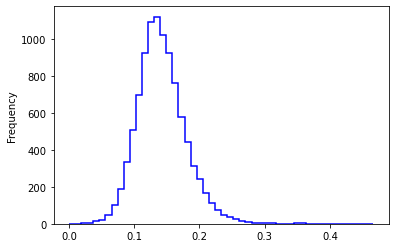

In [134]:
data.plot(kind='hist',histtype='step',
          color='b',label='F3 fraction', bins=bins, linewidth=linewidth)


In [135]:



def make_fig_b(ax):
    bins=50
    col = 'P_freq'

    #fig,ax = plt.subplots(figsize=(12,6))
    data = temp[temp['in_proteomics']==1][col]
    weights = np.ones_like(data) / len(data)
    data.plot(kind='hist',weights=weights, ax=ax, histtype='step',
              color='b',label='F3 fraction', bins=bins, linewidth=linewidth)

    data = temp[temp['is_mucin']==1][col]
    weights = np.ones_like(data) / len(data)
    data.plot(kind='hist',weights=weights, ax=ax, histtype='step',
              color='g',label='Mucins',bins=bins, linewidth=linewidth)

    data = temp[(temp['is_mucin']==0) & (temp['in_proteomics']==0)][col]
    weights = np.ones_like(data) / len(data)
    data.plot(kind='hist',weights=weights, ax=ax, histtype='step',
              color='r',label='Proteome', bins=bins, linewidth=linewidth)

    
    hist_legend(ax)

    fontProperties = {'family':'Arial',
        'weight' : 'normal', 'size' : 14}
    fontProperties_names = {'family':'Arial',
        'weight' : 'bold', 'size' : 14}

    ax.set_xlabel('Frequency',fontdict=fontProperties_names)
    ax.set_ylabel('Normalized Counts', fontdict=fontProperties_names)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')

    #title = 'Proline Frequency'
    #plt.title(title,fontdict=fontProperties_names)

    xmin, xmax = ax.get_xlim()


    temp_xticks=[n for n in np.arange(-0.01, 0.25, 0.05)]
    #print(temp_xticks)
    ax.set_xticks(temp_xticks)

    ymin, ymax = ax.get_ylim()
    ax.set_xlim(-0.015,0.26)
    ax.spines['bottom'].set_bounds(-0.01, 0.24)

    ax.set_ylim(0,0.13)
    ax.spines['left'].set_bounds(0, 0.12)
    #print(xmin, xmax, ymin, ymax )
    #fig.savefig('Fig2.png')
    #plt.show()
                        

In [136]:
proteome_gpi = temp[ temp['GPI_pred']==1 ]
fraction = temp[ temp['in_proteomics']==1 ]
fraction_gpi = temp[ (temp['in_proteomics']==1) & (temp['GPI_pred']==1) ]

proteome_signalP = temp[ temp['SigP_pred']==1 ]
fraction_signalP = temp[ (temp['in_proteomics']==1) & (temp['SigP_pred']==1) ]
print(temp.shape[0], proteome_gpi.shape[0], 
      fraction.shape[0], fraction_gpi.shape[0])


11312 1106 871 422


In [137]:
from scipy import stats
#N # population size
#G # number of good elements in population
#n = # simple random sample size
gpi_enrich = stats.hypergeom.pmf(
                    fraction_gpi.shape[0], 
                    temp.shape[0], 
                    proteome_gpi.shape[0], 
                    fraction.shape[0])

signalP_enrich = stats.hypergeom.pmf(
                    fraction_signalP.shape[0], 
                    temp.shape[0], 
                    
                    proteome_signalP.shape[0], 
                    fraction.shape[0])


In [138]:
print('''T. theileri proteome n={n1}
T. theileri gpi n={n2}
T. theileri F3 n={n3}
T. theileri F3 gpi n={n4}
enrichment pvalue={pval:.2e}'''.format(
    n1=temp.shape[0],
    n2=proteome_gpi.shape[0],
    n3=fraction.shape[0],
    n4=fraction_gpi.shape[0],
    pval=gpi_enrich))
print('recovered 1/2 of the proteins with a Signal peptide')

T. theileri proteome n=11312
T. theileri gpi n=1106
T. theileri F3 n=871
T. theileri F3 gpi n=422
enrichment pvalue=2.68e-216
recovered 1/2 of the proteins with a Signal peptide


In [139]:
print('''T. theileri proteome n={n1}
T. theileri Signal Peptide n={n2}
T. theileri F3 n={n3}
T. theileri F3 Signal Peptide n={n4}
enrichment pvalue={pval:.2e}'''.format(
    n1=temp.shape[0],
    n2=proteome_signalP.shape[0],
    n3=fraction.shape[0],
    n4=fraction_signalP.shape[0],
    pval=signalP_enrich))
print('recovered 1/3 of the proteins with a Signal peptide')

T. theileri proteome n=11312
T. theileri Signal Peptide n=1442
T. theileri F3 n=871
T. theileri F3 Signal Peptide n=451
enrichment pvalue=5.13e-192
recovered 1/3 of the proteins with a Signal peptide


In [140]:
#counts_mucin.shape[0]

In [141]:
def make_fig_c(ax):
    counts_proteomics = temp[temp['in_proteomics']==1]
    counts_mucin = temp[temp['is_mucin']==1]

    common = len(set(counts_proteomics.index.values) & set(counts_mucin.index.values))

    #fig,ax = plt.subplots()
    venn2(subsets = (counts_proteomics.shape[0]-common, 
                 counts_mucin.shape[0]-common,
                 common ), 
      set_labels = ('F3 fraction', 'Mucins'), ax=ax)
    #plt.title('T. theileri Proteome')
    #fig.savefig('Fig3.png')
    #plt.show()

In [142]:
#counts_signalP.shape

In [143]:
def make_fig_d(ax):
    counts_proteomics = temp[temp['in_proteomics']==1].shape[0]
    counts_gpi = temp[(temp['in_proteomics']==1) & (temp['GPI_pred']==1)]
    counts_signalP = temp[(temp['in_proteomics']==1) & (temp['SigP_pred']==1)]
    common = len(set(counts_gpi.index.values) & set(counts_signalP.index.values))

    #fig,ax = plt.subplots()
    venn2(subsets = (counts_gpi.shape[0]-common, 
                     counts_signalP.shape[0]-common, 
                     common ), 
          set_labels = ('GPI prediction', 'Signal Peptide Prediction'), ax=ax)

    #plt.title('F3 fraction T. theileri')
    #fig.savefig('Fig4.png')
    #plt.show()

In [157]:
def set_fig_label(ax,text):
    ax.text(-0.1, 1.1, text+')', 
                horizontalalignment='center',
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)

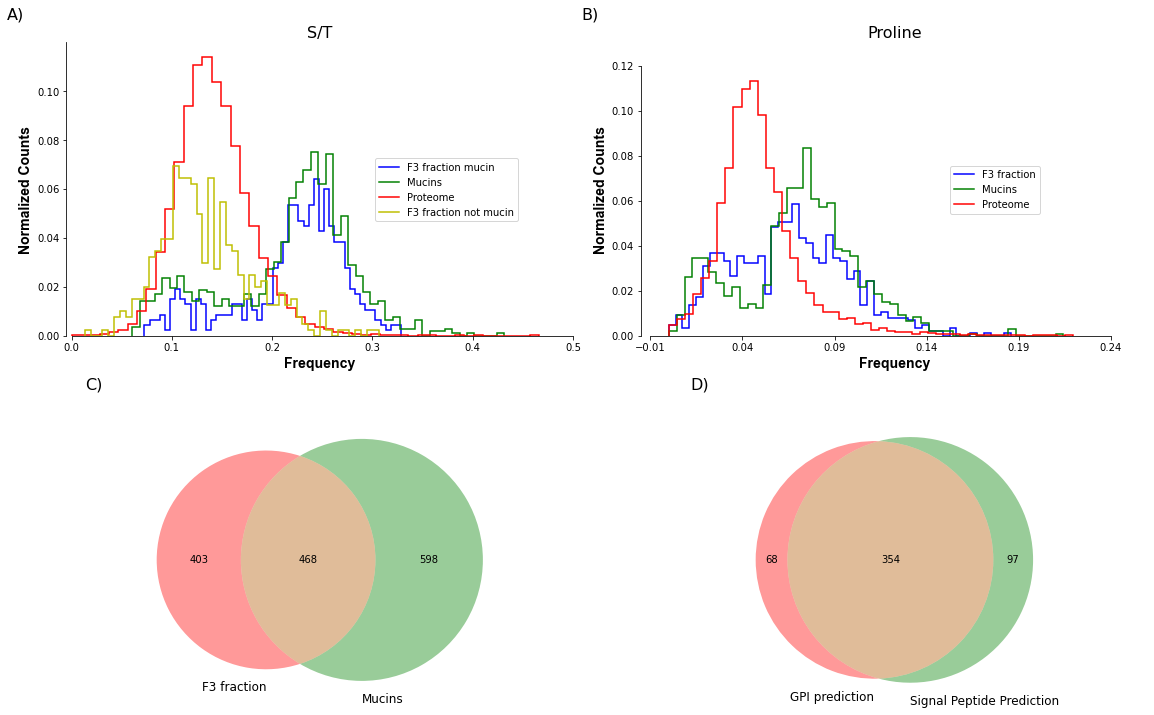

In [171]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


def hist_legend(ax, title = False):
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=new_handles, labels=labels, 
    title=title,loc='center left', bbox_to_anchor=(0.6, 0.5))  


fig,axes = plt.subplots(figsize=(16,10), ncols=2,nrows=2)
make_fig_d(axes[1,1])
set_fig_label(axes[1,1],'D')

make_fig_c(axes[1,0])
set_fig_label(axes[1,0],'C')

make_fig_b(axes[0,1])
set_fig_label(axes[0,1],'B')

make_fig_a(axes[0,0])
set_fig_label(axes[0,0],'A')

axes[0,0].set_title('S/T',fontsize=16)
axes[0,1].set_title('Proline',fontsize=16)
plt.tight_layout()
plt.savefig('Figure_2.png')
plt.savefig('Figure_2.svg')
plt.show()

In [166]:
354+97

451